In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os

# this is necessary for tensorflowjswizard
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Import & Model load

In [33]:
use_model_path = '/content/drive/MyDrive/ndev-task-tracker/universal-sentence-encoder-tensorflow1-lite-v2'

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import sentencepiece as spm
from sklearn.model_selection import train_test_split

In [35]:
print(tf.__version__)

2.18.0


In [36]:
embed = hub.load(use_model_path)
sp = spm.SentencePieceProcessor()
sp.load(f"{use_model_path}/assets/universal_encoder_8k_spm.model")

True

In [37]:
embed_fn = embed.signatures["default"]

# Data Preparation

In [38]:
# USE Lite is designed to be smaller and mobile/web-friendly, so it does not contain its own tokenizer.
# because the embed_fn signature of the Universal Sentence Encoder Lite model you loaded expects the input in this sparse format. If you tried to pass a dense tensor or just a list of token IDs directly, the model would likely throw an error.

def to_sparse(sentences):
    # Encode sentences to list of token ids
    ids = [sp.encode(s) for s in sentences]

    # Create values and indices for SparseTensor
    values = [token for sent in ids for token in sent]
    indices = [[i, j] for i, sent in enumerate(ids) for j in range(len(sent))]
    dense_shape = [len(ids), max(len(sent) for sent in ids)]

    # Convert to required tensors
    return {
        "values": tf.constant(values, dtype=tf.int64),
        "indices": tf.constant(indices, dtype=tf.int64),
        "dense_shape": tf.constant(dense_shape, dtype=tf.int64),
    }


note: dataset size are not affecting the model size (explicitly)

In [92]:
import os

valid_title = [
    "project sprint 1",
    "project sprint 5",
    "project sprint 1.1",
    "project sprint 5.1",
    "taskhive dev",
    "ndev task tracker",
    "spenicle v1",
    "zenventory",
    "flownest",
    "contact app",
    "property web app",
    "pronews"
]

meetings = [
    "project backlog refinement",
    "planning sprint",
    "sprint retrospective session",
    "designing system architecture",
    "project discussion",
    "soda",
    "1:1 with manager",
    "attending a meeting",
    "developer catchup",
    "daily standup",
    "daily meeting",
    "internal meeting",
    "running daily standup",
    "meeting with mr colleague",
    "meet with mrs jane",
    "daily scrum meeting",
    "brainstorming session",
    "weekly sync up",
    "team meeting",
    "client call",
    "quarterly review",
    "stand-up meeting",
    "sync meeting",
    "discussion with the team",
    "meeting with stakeholders",
    "project review meeting",
    "technical discussion",
    "design review meeting",
    "planning meeting for next quarter",
    "client demo session",
    "internal team sync",
    "meeting with product manager",
    "daily huddle",
    "weekly planning session"
]

background_task = [
    "setting up ci/cd",
    "configuring docker",
    "writing api spec",
    "deploying app",
    "refactoring code",
    "writing documentation",
    "resolving merge conflicts",
    "committing changes",
    "optimizing database",
    "managing backlog",
    "setting up continuous integration and deployment pipelines",
    "docker container configuration",
    "api contract documentation",
    "application deployment to production",
    "codebase refactoring",
    "technical documentation creation",
    "resolving git merge conflicts",
    "pushing code to remote repository",
    "committing code changes",
    "database performance optimization",
    "project backlog grooming",
    "configuring build automation",
    "writing user guides",
    "resolving version control conflicts",
    "deploying a new service",
    "improving database query performance"
]

general_tasks = [
    "writing code",
    "fixing bugs",
    "reviewing prs",
    "reviewing code",
    "fixing linter issues",
    "updating documentation",
    "pair programming",
    "resolving bugs",
    "preparing presentation",
    "presenting updates",
    "discussing roadmap",
    "collaborating on design",
    "writing proposal",
    "self explore",
    "self research",
    "research and found issue with memory optimization in react components",
    "bug research",
    "debugging application errors",
    "conducting code reviews",
    "addressing static analysis warnings",
    "updating technical specifications",
    "collaborative coding session",
    "troubleshooting and resolving software defects",
    "creating slides for presentation",
    "providing project updates",
    "discussing project roadmap",
    "collaborating on system design",
    "writing a technical proposal",
    "exploring new technologies for a project",
    "conducting technical research",
    "investigating memory issues in frontend components",
    "researching software bugs",
    "works on analytics dashboard"
]

general_activities = [
    "afternoon prayer",
    "watching a movie",
    "playing games",
    "eating out",
    "scrolling tiktok",
    "cooking dinner",
    "taking a nap",
    "chatting with friends",
    "binge-watching netflix",
    "reading a novel",
    "doing laundry",
    "shopping online",
    "going to the mall",
    "napping",
    "watching youtube",
    "cleaning room",
    "going for a walk",
    "checking social media",
    "ordering food",
    "scrolling instagram",
    "taking a break",
    "technical training",
    "english class",
    "compliance training session",
    "web development security training",
    "training assesment",
    "prayer time in the afternoon",
    "watching a film for leisure",
    "playing video games for relaxation",
    "dining at a restaurant",
    "browsing short videos on tiktok",
    "preparing a meal for dinner",
    "taking a short rest",
    "talking with colleagues informally",
    "watching multiple episodes on netflix",
    "reading a fiction book",
    "doing the weekly laundry",
    "purchasing items online",
    "visiting a shopping mall",
    "getting some sleep",
    "watching videos on youtube for entertainment",
    "tidying up the living space",
    "going for a short walk outside",
    "checking updates on social media platforms",
    "ordering food for delivery",
    "browsing photos and videos on instagram",
    "taking a short pause from work",
    "attending a technical skill building session",
    "participating in an English language course",
    "completing mandatory compliance training",
    "attending a web security workshop",
    "undergoing a training evaluation"
]

# can be useful when no valid_title detected
project_tasks = [
    "working on a new ui design",
    "create new component for new page",
    "resolve feedback: update the formatData approach",
    "resolve feedback from mr. xxx",
    "working on a new feature",
    "working on the new drawer",
    "adjust the page gdpr message",
    "handle form submit behaviour",
    "writing unit tests",
    "debugging memory leak",
    "benchmarking app",
    "works on progressive web app features",
    "works on error tracking implementation",
    "works on user interface improvements",
    "works on data migration scripts",
    "works on mobile responsive design",
    "works on blockchain integration research",
    "designing a new user interface for the application",
    "developing a reusable component for a new page",
    "addressing feedback on the data formatting logic",
    "implementing changes based on feedback from a team member",
    "building a new feature based on requirements",
    "working on the implementation of a new navigation drawer",
    "modifying the gdpr consent message displayed on the page",
    "implementing the logic for form submission and validation",
    "writing comprehensive unit tests for a module",
    "investigating and fixing a memory leak issue",
    "conducting performance benchmarking for the application"
]

dataset_dict = {
    "valid_title": valid_title,
    "background_task": background_task,
    "meetings": meetings,
    "general_tasks": general_tasks,
    "general_activities": general_activities,
    "project_tasks": project_tasks,
}

## Back-translation

english -> france -> english

warning: this section can take long time

this is not required to run, as the original dataset is quite sufficient

In [40]:
from transformers import MarianMTModel, MarianTokenizer

# Load models for English → French and French → English
en_to_fr_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
en_to_fr_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

fr_to_en_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
fr_to_en_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-fr-en")


/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [41]:
def translate(text, tokenizer, model):
    inputs = tokenizer.encode(text, return_tensors="pt")
    outputs = model.generate(inputs, max_length=64, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def back_translate(text):
    """
    Performs back-translation from English to French and then back to English.

    Returns:
        str: The back-translated English text.
    """
    fr_text = translate(text, en_to_fr_tokenizer, en_to_fr_model)
    back_to_en = translate(fr_text, fr_to_en_tokenizer, fr_to_en_model)
    return back_to_en

In [42]:
background_task_bt = []
meetings_bt = []
general_tasks_bt = []
general_activities_bt = []
project_tasks_bt = []

# Back-translate sentences for each category (excluding valid_title)
for sentence in background_task:
    background_task_bt.append(back_translate(sentence))

for sentence in meetings:
    meetings_bt.append(back_translate(sentence))

for sentence in general_tasks:
    general_tasks_bt.append(back_translate(sentence))

for sentence in general_activities:
    general_activities_bt.append(back_translate(sentence))

for sentence in project_tasks:
    project_tasks_bt.append(back_translate(sentence))


print("Back-translated background_tasks:", background_task_bt[:5])
print("Back-translated meetings:", meetings_bt[:5])
print("Back-translated general_tasks:", general_tasks_bt[:5])
print("Back-translated general_activities:", general_activities_bt[:5])
print("Back-translated project_tasks:", project_tasks_bt[:5])

KeyboardInterrupt: 

In [ ]:
import pickle

# Create a dictionary to store the back-translated data
back_translated_data_dict = {
    "background_task_bt": background_task_bt,
    "meetings_bt": meetings_bt,
    "general_tasks_bt": general_tasks_bt,
    "general_activities_bt": general_activities_bt,
    "project_tasks_bt": project_tasks_bt
}

# Define the filename for the pickle file
pickle_filename = "back_translated_data.pkl"

# Save the dictionary to a pickle file
with open(pickle_filename, 'wb') as f:
    pickle.dump(back_translated_data_dict, f)

print(f"Back-translated data saved to {pickle_filename}")

## Preprocessing

In [93]:
# for evaluation
class_names = [
    "valid_title",
    "background_task",
    "meetings",
    "general_tasks",
    "general_activities",
    "project_tasks",
]

# Combine all with labels
raw_data = []
raw_data += [(item, 0) for item in valid_title]
raw_data += [(item, 1) for item in background_task]
raw_data += [(item, 2) for item in meetings]
raw_data += [(item, 3) for item in general_tasks]
raw_data += [(item, 4) for item in general_activities]
raw_data += [(item, 5) for item in project_tasks]

print('You have ', len(raw_data), 'data points')

You have  185 data points


In [94]:
sentences = []
labels = []

for sentence, label in raw_data:
    sentences.append(sentence.lower())
    labels.append(label)

sentences = np.array(sentences)
labels = np.array(labels)

# Display the first few elements to verify
print(f"First 5 sentences: {sentences[:5]}")
print(f"First 5 labels: {labels[:5]}")

First 5 sentences: ['project sprint 1' 'project sprint 5' 'project sprint 1.1'
 'project sprint 5.1' 'taskhive dev']
First 5 labels: [0 0 0 0 0]


In [95]:
sparse_input = to_sparse(sentences)
embeddings = embed_fn(**sparse_input)['default']

## Data splitting

In [99]:
x_train, x_val, y_train, y_val = train_test_split(
    embeddings.numpy(), labels, test_size=0.15, stratify=labels, random_state=5
)

print(len(x_train), len(x_val))

157 28


In [100]:
import collections

# Check if y_val have proper distribution
y_val_counts = collections.Counter(y_val)

# Print the counts for each class
print("Distribution of classes in y_val:")
for label, count in y_val_counts.items():
    print(f"Class {class_names[label]}: {count}")

Distribution of classes in y_val:
Class project_tasks: 4
Class background_task: 4
Class general_activities: 8
Class general_tasks: 5
Class meetings: 5
Class valid_title: 2


## prod setup

In [120]:
# combine all dataset for final result

x_train = np.concatenate((x_train, x_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)
len(x_train)

185

# Training

In [121]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512,)),
    tf.keras.layers.Dense(55, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(x_train, y_train, epochs=75)

Epoch 1/75
6/6 [==============================] - 1s 3ms/step - loss: 1.7664 - accuracy: 0.3189
Epoch 2/75
6/6 [==============================] - 0s 3ms/step - loss: 1.7131 - accuracy: 0.5189
Epoch 3/75
6/6 [==============================] - 0s 3ms/step - loss: 1.6500 - accuracy: 0.5676
Epoch 4/75
6/6 [==============================] - 0s 3ms/step - loss: 1.5906 - accuracy: 0.5189
Epoch 5/75
6/6 [==============================] - 0s 3ms/step - loss: 1.5139 - accuracy: 0.5568
Epoch 6/75
6/6 [==============================] - 0s 3ms/step - loss: 1.4340 - accuracy: 0.6054
Epoch 7/75
6/6 [==============================] - 0s 3ms/step - loss: 1.3513 - accuracy: 0.6432
Epoch 8/75
6/6 [==============================] - 0s 3ms/step - loss: 1.2899 - accuracy: 0.6703
Epoch 9/75
6/6 [==============================] - 0s 3ms/step - loss: 1.2100 - accuracy: 0.6811
Epoch 10/75
6/6 [==============================] - 0s 3ms/step - loss: 1.1649 - accuracy: 0.7514
Epoch 11/75
6/6 [======================

## evaluation

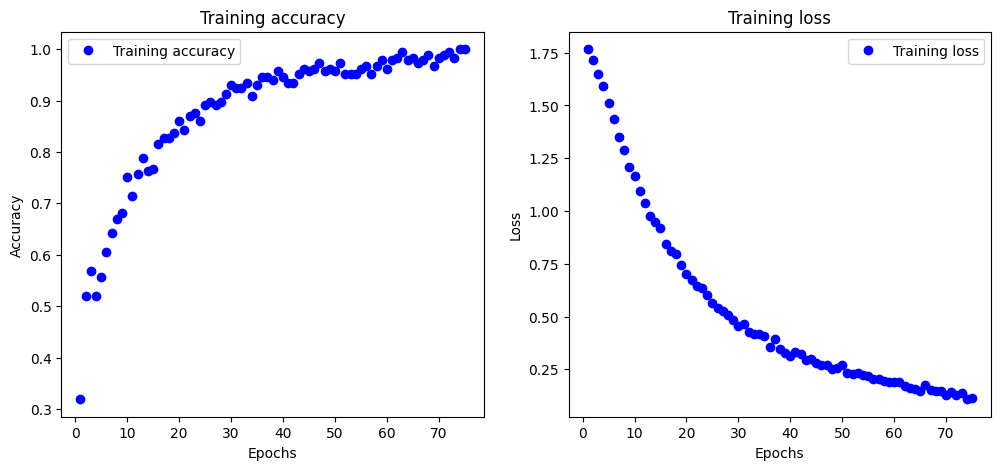

In [122]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
history_dict = history.history
acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [123]:
loss, acc = model.evaluate(x_val, y_val, verbose=0)
print(f"Val Accuracy: {acc:.2%}")


Val Accuracy: 100.00%


In [126]:
new_sentences = ["my app v1", "works on container orchestration setup", "works on analytics dashboard", "eating a little pizza for a minute and wrote a code", "catchup with mr x", "Quarterly system architecture review meeting"]
new_input = to_sparse(new_sentences)
new_embeddings = embed_fn(**new_input)['default']

predictions = model.predict(new_embeddings)
confidences = predictions.max(axis=1)
print(confidences)
predicted_labels = predictions.argmax(axis=1)
predicted_class_names = [class_names[label] for label in predicted_labels]
print(predicted_class_names)


1/1 [==============================] - 0s 133ms/step
[0.55845195 0.48892674 0.63322455 0.8075711  0.75991756 0.94099194]
['valid_title', 'project_tasks', 'general_tasks', 'general_activities', 'meetings', 'meetings']


# Save Model

In [125]:
model.save('saved_model.h5')

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
